<a href="https://colab.research.google.com/github/aniketmaurya/chitra/blob/master/nbs/image-classification-example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Chitra - Example 01
Training Image classification model for Cats vs Dogs Kaggle dataset.

To install chitra
`pip install --upgrade chitra==0.0.20`

In [ ]:
!pip install chitra -q

     |████████████████████████████████| 1.1MB 18.1MB/s eta 0:00:01


## import functions and classes
### Dataset Class
Dataset class has API for loading `tf.data`, image augmentation and progressive resizing.

### Trainer
The Trainer class inherits from tf.keras.Model, it contains everything that is required for training. It exposes trainer.cyclic_fit method which trains the model using Cyclic Learning rate discovered by Leslie Smith.


In [ ]:
import tensorflow as tf
from chitra.datagenerator import Dataset
from chitra.trainer import Trainer, create_cnn

from PIL import Image

In [ ]:
BS = 16
IMG_SIZE_LST = [(128,128), (160, 160), (224,224)]
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
def tensor_to_image(tensor):
    return Image.fromarray(tensor.numpy().astype('uint8'))

copy your kaggle key to `/root/.kaggle/kaggle.json` for downloading the dataset.

In [ ]:
!kaggle datasets download -d chetankv/dogs-cats-images
!unzip -q dogs-cats-images.zip

 98% 427M/435M [00:02<00:00, 161MB/s]
100% 435M/435M [00:02<00:00, 153MB/s]


In [ ]:
ds = Dataset('dog vs cat/dataset/training_set', image_size=IMG_SIZE_LST)

dogs


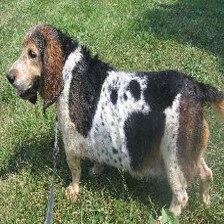

In [ ]:
image, label = ds[0]
print(label)
tensor_to_image(image).resize((224,224))

## Create Trainer

Train imagenet pretrained MobileNetV2 model with cyclic learning rate and SGD optimizer.

In [ ]:
trainer = Trainer(ds, create_cnn('mobilenetv2', num_classes=2))

In [ ]:
trainer.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
trainer.compile2(batch_size=BS,
                 optimizer='sgd',
                 lr_range=(1e-4, 1e-2),
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=['binary_accuracy'])

Model compiled!


In [ ]:
trainer.cyclic_fit(10, batch_size=BS)

cyclic learning rate already set!
Epoch 1/10
500/500 [==============================] - 40s 80ms/step - loss: 0.4258 - binary_accuracy: 0.7878
Epoch 2/10
500/500 [==============================] - 50s 101ms/step - loss: 0.1384 - binary_accuracy: 0.9438
Epoch 3/10
500/500 [==============================] - 79s 159ms/step - loss: 0.0587 - binary_accuracy: 0.9771
Epoch 4/10
Returning the last set size which is: (224, 224)
500/500 [==============================] - 79s 158ms/step - loss: 0.0385 - binary_accuracy: 0.9841
Epoch 5/10
Returning the last set size which is: (224, 224)
500/500 [==============================] - 79s 158ms/step - loss: 0.0257 - binary_accuracy: 0.9911
Epoch 6/10
Returning the last set size which is: (224, 224)
500/500 [==============================] - 79s 158ms/step - loss: 0.0302 - binary_accuracy: 0.9901
Epoch 7/10
Returning the last set size which is: (224, 224)
500/500 [==============================] - 79s 158ms/step - loss: 0.0212 - binary_accuracy: 0.9931
E

Trainer also supports the regular keras `model.fit` api using `trainer.fit`

Train the same model **without cyclic learning rate**:

In [ ]:
trainer = Trainer(ds, create_cnn('mobilenetv2', num_classes=2))
trainer.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['binary_accuracy'])

In [ ]:
data = ds.get_tf_dataset().map((lambda x,y: (x/127.5-1.0, y)), AUTOTUNE).batch(BS).prefetch(AUTOTUNE)

trainer.fit(data,
            epochs=10)

Epoch 1/10
500/500 [==============================] - 38s 77ms/step - loss: 0.4070 - binary_accuracy: 0.8026
Epoch 2/10
500/500 [==============================] - 50s 99ms/step - loss: 0.1800 - binary_accuracy: 0.9239
Epoch 3/10
500/500 [==============================] - 78s 155ms/step - loss: 0.1197 - binary_accuracy: 0.9553
Epoch 4/10
Returning the last set size which is: (224, 224)
500/500 [==============================] - 79s 158ms/step - loss: 0.0952 - binary_accuracy: 0.9626
Epoch 5/10
Returning the last set size which is: (224, 224)
500/500 [==============================] - 78s 157ms/step - loss: 0.0809 - binary_accuracy: 0.9664
Epoch 6/10
Returning the last set size which is: (224, 224)
500/500 [==============================] - 77s 154ms/step - loss: 0.0693 - binary_accuracy: 0.9735
Epoch 7/10
Returning the last set size which is: (224, 224)
500/500 [==============================] - 78s 156ms/step - loss: 0.0610 - binary_accuracy: 0.9759
Epoch 8/10
Returning the last set si

# What does model focus on while making a prediction?
`chitra.trainer.InterpretModel` class creates GradCAM and GradCAM++ visualization in no additional code!

In [ ]:
from chitra.trainer import InterpretModel
import random
model_interpret = InterpretModel(True, trainer)

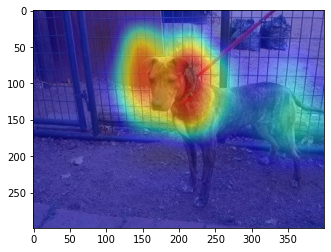

In [ ]:
image_tensor = random.choice(ds)[0]
image = tensor_to_image(image_tensor)
model_interpret(image, auto_resize=False)